Authors: **Christophe HAIKAL and Hugo PREVOTEAU**

# NLP Project 1

## Menu
**Our work is divided in the following parts: <br>**
[Imports](#Imports): importing libraries and data<br>
[Preprocessing](#Preprocessing): scrapping the XML file to create our dataframe <br>
[Visualisation](#Visualisation): visualizing our dataset <br>

**Our three tested approaches: <br>**
[TF-IDF](#TF-IDF): clustering the articles using TD-IDF and KMEANS <br>
[LDA](#LDA): LDA for topic modelling <br>
[Doc2Vec](#Doc2Vec): Document embedding and KMEANS cosine clustering, validading the approach with TF-IDF's keywords embedding using Word2Vec

**Sources:**<br>
**TF-IDF**: Jones, K.S.: A statistical interpretation of term specicity and its application in
retrieval<br>
**LDA**: David M. Blei et al.: Latent Dirichlet Allocation (https://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf) <br>
**Doc2Vec**: Quoc V. Le et al.: Distributed Representations of Sentences and Documents (https://arxiv.org/abs/1405.4053)<br>
**Word2Vec**: Tomas Mikolov et al.: Efficient Estimation of Word Representations in Vector Space (https://arxiv.org/abs/1301.3781)
<br>
**KMEANS**: Steinhaus: Sur la division des corps mat ́eriels en parties.

# Imports

### Libraries

In [1]:
import pandas as pd
import numpy as np
import re
from wordcloud import WordCloud
from collections import Counter
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import CountVectorizer
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import gensim
import matplotlib.cm as cm


In [133]:
import warnings
warnings.filterwarnings('ignore')

### Gathering the data

In [2]:
infile = open("C:/Users/hugop/Desktop/corpus-taln/corpus_taln_v1.tei.xml","r", encoding='UTF-8')
contents = infile.read()
soup = BeautifulSoup(contents,'xml')

In [3]:
soup.bibl.clear()

# Preprocessing

#### Scrapping

*We use the XML tags to retrieve information that we want, using beaufitul soup, since XML and HTML work the same way*

*authors*

In [4]:
author = soup.find_all('text')

In [5]:
selector = {'xml:lang':["fr","en"]}
titles = soup.find_all('title', selector)

In [6]:
title = []
for x in titles:
    title.append(x.text.replace('\n',''))
title = list(dict.fromkeys(title))

In [7]:
titles_list = []
for x in titles:
    titles_list.append(str(x))

In [8]:
titles_list = list(dict.fromkeys(titles_list))

*languages*

In [9]:
language = []
for x in titles_list:
    language.append(re.search('\"(.*)\"', x).group(1))

*texts*

In [10]:
paragraphs = []
for x in author:
    paragraphs.append(BeautifulSoup(str(x), "lxml").text.replace('\n\n\n\n\n',' ').replace('\n\n\n\n',' ').replace('\n\n\n',' ').replace('\n\n',' ').replace('\n',' ').replace("\'","").replace('None ','').replace('  ',' '))

In [11]:
paragraphs_clean = []
regex = re.compile(".?((.?))")
for x in paragraphs:
    paragraphs_clean.append(re.sub("([\(\[]).*?([\)\]])", "\g<1>\g<2>", x).replace('[]', '').replace('()', '').replace('  ', ' ').replace(' .','.'))
paragraphs_clean = list(dict.fromkeys(paragraphs_clean))

*dates*

In [12]:
dates = soup.find_all('imprint') #we use this tag because its unique in each article, avoids duplicates

*conference*

In [13]:
conf = soup.find_all('fileDesc', {"xml:id": re.compile('^r|t')})

In [14]:
conf = conf[1:] ##supprimer le fileDesc qui correspond à la description du fichier xml

In [15]:
conferences = []
for x in conf:
    conferences.append(str(x).replace('-', '"'))

In [16]:
conferences_clean = []
for x in conferences:
    conferences_clean.append(re.search('\"(.*)\"', x).group(1))

In [17]:
conferences_clean_2 = []
for x in conferences_clean:
    if x[0] == 't':
        x = x[0:4]
    else:
        x = x[0:7]
    conferences_clean_2.append(x)

In [18]:
date = []
for x in dates:
    date.append(x.get_text().replace('\n',''))

*Once we scrapped all the data we can zip the lists into a single pandas dataframe that we'll use later*

In [19]:
#filling a dataframe with the scrapped data
df = pd.DataFrame(list(zip(paragraphs_clean, language,title, date,conferences_clean_2)), columns =['Text', 'Language','name', 'date', 'conference']) 

In [20]:
df_fr = df[df['Language'] == 'fr'] #we focus on french papers only for this part

In [21]:
df_fr = df_fr[df_fr['Text'].str.len() > 2570] #we delete the articles with no text body

In [22]:
Counter(list(df_fr['conference']))

Counter({'taln': 1089, 'recital': 196})

#### Lowercasing the text

In [23]:
df_fr['Text'] = df_fr['Text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
df_fr['Text'].head()

0    nous considérons dans notre travail la tâche d...
1    nous donnons ici un aperçu du logiciel decid d...
3    le terme de lambda-drt désigne un ensemble de ...
4    dans cet article, nous comparons deux modèles ...
5    dans le cadre des approches à base de grammair...
Name: Text, dtype: object

#### Removing the stopwords

In [24]:
from nltk.corpus import stopwords
stop = stopwords.words('french')
df_fr['Text'] = df_fr['Text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df_fr['Text'].head()

0    considérons travail tâche traitement automatiq...
1    donnons ici aperçu logiciel decid développé ge...
3    terme lambda-drt désigne ensemble méthodes per...
4    cet article, comparons deux modèles linguistiq...
5    cadre approches base grammaires faiblement sen...
Name: Text, dtype: object

#### Removing the punctuation

In [25]:
df_fr['Text'] = df_fr['Text'].str.replace('[^\w\s]','')

#### Lemmatization

*We didn't use this, since we think that the french lemmatizer is not good enough*

#### Stemming

In [26]:
df_fr['Text_no_stemming'] = df_fr['Text']

In [27]:
from nltk.stem.snowball import FrenchStemmer
stemmerFR = FrenchStemmer()
df_fr['Text'] = df_fr.apply(lambda x: " ".join([stemmerFR.stem(word) for word in x['Text'].split()]), axis = 1)

In [28]:
df_fr['Text'].head()

0    considéron travail tâch trait automat vis cons...
1    donnon ici aperçu logiciel decid développ get ...
3    term lambdadrt désign ensembl méthod permet co...
4    cet articl comparon deux model linguist utilis...
5    cadr approch bas grammair faibl sensibl contex...
Name: Text, dtype: object

# Visualisation

#### N-grams

In [29]:
def get_top_text_ngrams(corpus, n, g):
    vec = CountVectorizer(ngram_range = (g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis = 0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

def plot_most_freq_ngram(n,text):
    most_common_gram = get_top_text_ngrams(text,20,n)
    most_common_gram = dict(most_common_gram)
    temp = pd.DataFrame(columns = ["Common_words" , 'Count'])
    temp["Common_words"] = list(most_common_gram.keys())
    temp["Count"] = list(most_common_gram.values())
    fig = px.bar(temp, x = "Count", y = "Common_words", title = 'Commmon Words in Ngram', orientation = 'h', 
                 width = 700, height = 700,color = 'Common_words')
    fig.show()

In [30]:
#top 1grams
plot_most_freq_ngram(1,df_fr['Text'])

In [31]:
#top bigrams
plot_most_freq_ngram(2,df_fr['Text'])

In [32]:
#top 3grams
plot_most_freq_ngram(3,df_fr['Text'])

#### Barplot

*We can notice there's much more articles in TALN than recital*

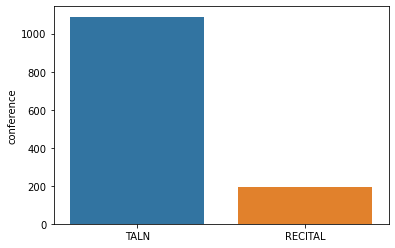

In [33]:
sns.barplot(x=['TALN', 'RECITAL'], y=df_fr['conference'].value_counts());

#### Bart Chart Race

In [34]:
df_fr['count'] = 1
group_df_fr = pd.DataFrame(df_fr.groupby(['conference','date']).sum()).reset_index(drop=False)

In [35]:
group_df_fr = group_df_fr.set_index('date')

In [36]:
table = pd.pivot_table(group_df_fr, values='count', index=['date'],
                    columns=['conference'], aggfunc=np.sum)
table['recital'] = table['recital'].fillna(0)

In [37]:
table.recital = table.recital.astype(int)
table.taln = table.taln.astype(int)

In [38]:
table['sum_recital'] = table.recital.cumsum()
table['sum_taln'] = table.taln.cumsum()

In [39]:
table = table.drop(columns=['recital', 'taln'])

In [40]:
table= table.rename(columns={"sum_recital": "recital", "sum_taln": "taln"})

In [41]:
import bar_chart_race as bcr

*should be playable*

In [42]:
bcr.bar_chart_race(table,title='Number of articles published per conference', interpolate_period=False, period_label=True, colors='dark12')

#### WordCloud

*We use WordCloud library to visualize most occurent words in the titles, after removing the stopwords*

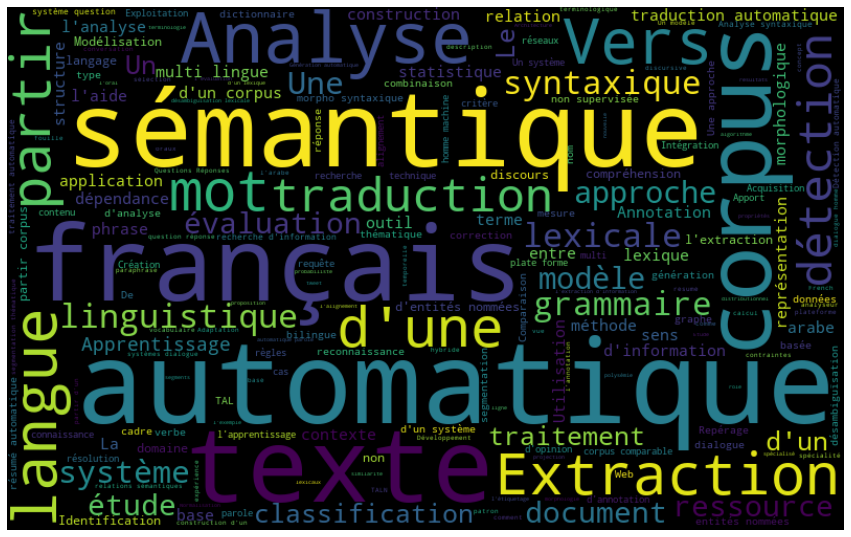

In [43]:
df_fr['name_sans_stopwords'] = df_fr['name'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
all_text = ' '.join([text for text in list(df_fr['name_sans_stopwords'])])

wordcloud = WordCloud(width=800, height=500,
                      random_state=21, max_font_size=110).generate(all_text)
plt.figure(figsize=(15, 12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off');

# TF-IDF

*Our first method, using the TF-IDF to retrieve the top keywords per article*

In [148]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://scontent.xx.fbcdn.net/v/t1.15752-9/51236090_1007789359414867_8046589901564542976_n.png?_nc_cat=110&ccb=2&_nc_sid=ae9488&_nc_ohc=0rwhFiBUsIMAX_tl11U&_nc_ad=z-m&_nc_cid=0&_nc_ht=scontent.xx&oh=6416bc348810565c51e10d3041848368&oe=5FF35345")

*TF-IDF, which stands for term frequency — inverse document frequency, is a scoring measure widely used in information retrieval (IR) or summarization. TF-IDF is intended to reflect how relevant a term is in a given document. The intuition behind it is that if a word occurs multiple times in a document, we should boost its relevance as it should be more meaningful than other words that appear fewer times (TF). At the same time, if a word occurs many times in a document but also along many other documents, maybe it is because this word is just a frequent word; not because it was relevant or meaningful (IDF).*

##### TF-IDF

*max_df and min_df are respectively initialized to 0.8 and 0.2 to automatically delete all not relevant keywords. Making the matrix lighter.*

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2,
                                 use_idf=True, ngram_range=(1,1), stop_words=['proceedings','proceeding'])

%time tfidf_matrix = tfidf_vectorizer.fit_transform(list(df_fr['Text'])) #fit the vectorizer to reviews
print(tfidf_matrix.shape)

Wall time: 4.7 s
(1285, 849)


In [45]:
terms = tfidf_vectorizer.get_feature_names()

*functions to plot the top N words with the highest TF-IDF score per article*

In [46]:
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df
def top_feats_in_doc(Xtr, features, row_id, top_n=25):
    ''' Top tfidf features in specific document (matrix row) '''
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

def plot_most_freq_ngram_per_document(n,index, df ):
    top = top_feats_in_doc(tfidf_matrix,terms,index,n)
    name = df.name[index]
    fig = px.bar( x=top['tfidf'], y=top["feature"], title=f'Commmon Ngrams in {name}', orientation='h', 
                 width=700, height=700,color=top["feature"])
    fig.show()

In [47]:
top_B = []
for i in range(len(df_fr)):
    top_B.append(list(top_feats_in_doc(tfidf_matrix,terms,i).feature))

In [48]:
df_fr = df_fr.reset_index(drop=True)

In [49]:
for i in range(2): #len(df_fr)
    plot_most_freq_ngram_per_document(100,i,df_fr)

In [50]:
terms = tfidf_vectorizer.get_feature_names()

##### Clustering (K-MEANS)

*before clustering the data, we use two different metrics to define which number of clusters is correct to run KMEANS*

###### Silhouette Score

*The silhouette value is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation).  If most objects have a high value, then the clustering configuration is appropriate. The silhouette can be calculated with any distance metric, here we used the Euclidean distance. <br>
As is it not relevant and takes a lot of space we chose to switch this cell to markdown*

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

print(__doc__)

range_n_clusters = list(range(2,40))

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, X.shape[0] + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

*since the silhouette score doesn't really work, we need to use a different method*

###### Elbow Method

*In cluster analysis, the elbow method is a heuristic used in determining the number of clusters in a data set. The method consists of plotting the explained variation as a function of the number of clusters, and picking the elbow of the curve as the number of clusters to use.*

In [51]:
X = tfidf_matrix.toarray()

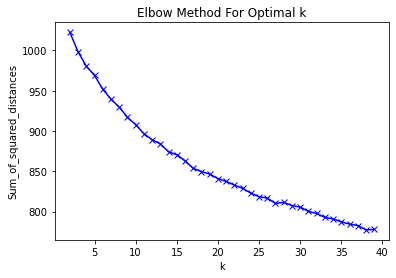

In [52]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist


a = tfidf_matrix.toarray()

Sum_of_squared_distances = []
K = range(2,40)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(a)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

*looking at this plot, we can tell that there is not really an elbow, we chose 14.*

*We could've had better scores by reducing the dimentions, but we couldn't know how much to reduce without reducing the relevance of the data. It would require empirical tests to determine which dimention we want to keep.*

###### Clustering with the optimal K = 14

In [53]:
num_clusters = 14

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix.toarray())

clusters = km.labels_.tolist()

Wall time: 3.24 s


###### Plotting the points with the optimal K = 14

In [54]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

*We reduce the dimension using MDS to plot the data*

In [55]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import MDS

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.

mds = MDS(n_components=3, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys, zs = pos[:, 0], pos[:, 1], pos[:,2]

In [56]:
df_plot3d = pd.DataFrame(list(zip(xs, ys, zs, clusters, df_fr['name'])), columns =['xs', 'ys', 'zs', 'clusters', 'title'])

##### 3D

In [57]:
import plotly.express as px

fig = px.scatter_3d(df_plot3d, x = 'xs',  
                    y = 'ys',  
                    z = 'zs', 
                    color = 'clusters',
                    title='3D scatter plot'
                    ) #text="title"
  
fig.show()

In [60]:
dic = { 'name': list(df_fr.name.values), 'Text': list(df_fr.Text.values), 'cluster': clusters}
frame = pd.DataFrame(dic, index = [clusters] , columns = [ 'name', 'cluster'])

In [61]:
#creating colors for the clusters

import matplotlib.cm as mplcm
import matplotlib.colors as colors

cm = plt.get_cmap('tab20b')
cNorm  = colors.Normalize(vmin=0, vmax=num_clusters-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
colors = [scalarMap.to_rgba(i) for i in range(num_clusters)]

In [70]:
#we manually set the cluster names according to the TF-IDF top keywords (shown bellow)
cluster_names = {0: 'Semantics', 
                 1: 'Question answering', 
                 2: 'Graphs for NLP', 
                 3: 'Lexicology', 
                 4: 'Annotation',
                 5: 'Topic modeling', 
                 6: 'Translation', 
                 7: 'Embeddings related papers', 
                 8: 'Summarization', 
                 9: 'Terminology extraction', 
                 10: 'POS Tagging',
                 11: 'Text classification',
                 12: 'Information retrieval',
                 13: 'Grammar'}

In [71]:
#getting the coordinates
xs, ys = pos[:, 0], pos[:, 1]

##### 2D

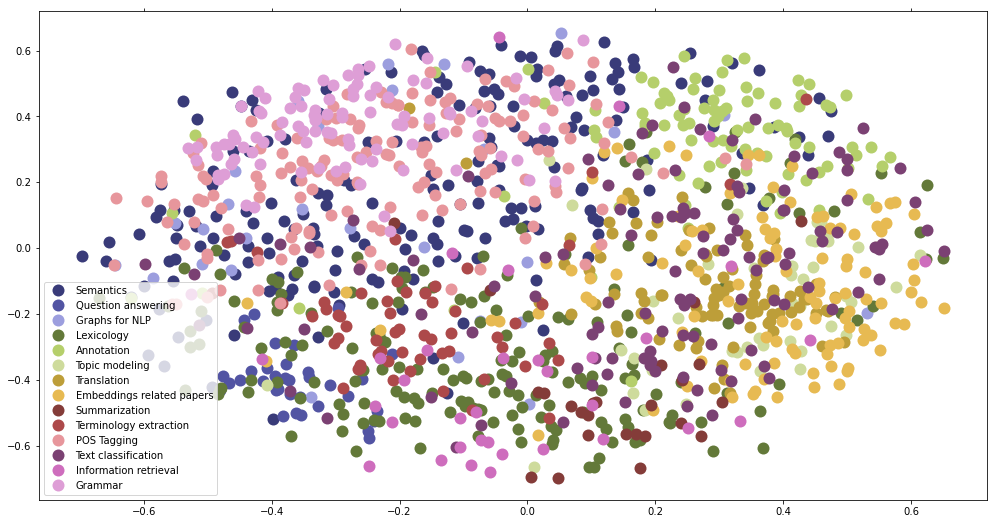

In [72]:
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=list(df_fr.name.values))) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=colors[int(name)], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.loc[i]['x'], df.loc[i]['y'], s=' ')  

    
    
plt.show() #show the plot

In [73]:
# Create a dataframe with the results
names = tfidf_vectorizer.get_feature_names()
data = tfidf_matrix.todense().tolist()
df_k = pd.DataFrame(data, columns=names)

#retrieving the top-10 most contributing words to the TF-IDF of each cluster
N = 10;
keywords= []
for i in df_k.iterrows():
    keywords.append(i[1].sort_values(ascending=False)[:25])

list_word=[]
for i in keywords:
    list_word.append(list(i.index))

list_coeff=[]
for i in keywords:
    list_coeff.append(list(i))

df_fr['words']=list_word
df_fr['coef']=list_coeff

list_word_coeff=[]
for i in range(len(list_coeff)):
    list_word_coeff.append(list(zip(list_word[i], list_coeff[i])))

In [147]:
list_word_coeff = list(zip(list_word, list_coeff))

df_fr['word_coeff']= list_word_coeff

*We group all the top keywords associated to each article in a cluster, and remove the duplicates: they are the cluster keywords*

In [75]:
df_fr['label'] = clusters

cluster_keywords = df_fr.groupby('label')['words'].apply(sum)

cluster_keywords = cluster_keywords.to_frame()

cluster_keywords['avg_keywords'] = cluster_keywords['words'].apply(lambda x: len(x))

def no_duplicate(liste):
    return list(dict.fromkeys(liste))

cluster_keywords['no_duplicate_keywords'] = cluster_keywords['words'].apply(lambda x: list(dict.fromkeys(x)))

cluster_keywords['avg_keywords_nodupli'] = cluster_keywords['no_duplicate_keywords'].apply(lambda x: len(x))

In [76]:
import seaborn as sns

from collections import Counter
import heapq
def topKFrequent(mylist,k): 
    # O(1) time 
    if k == len(mylist):
        return mylist

    # 1. build hash map : character and how often it appears
    # O(N) time
    count = Counter(mylist)   
    # 2-3. build heap of top k frequent elements and
    # convert it into an output array
    # O(N log k) time
    return heapq.nlargest(k, count.keys(), key=count.get) 

from collections import Counter 
from itertools import repeat, chain
top_keywords=[]
top_keywords_freq=[]
order=[]
N=10
for i in range(len(cluster_keywords)):
    top_keywords.append(topKFrequent(cluster_keywords.words[i],N))
    top_keywords_freq.append([x for x in cluster_keywords.words[i] if x in top_keywords[i]])
    order.append(no_duplicate(list(chain.from_iterable(repeat(i, c) 
         for i, c in Counter(cluster_keywords.words[i]).most_common())))[:N])

*We plot cluster's respective keywords*

In [77]:
for i in range(num_clusters):
    temp = pd.DataFrame(columns = ["Keywords" , 'Count'])
    temp["Keywords"] = list(order[i])
    occurencies = []
    for x in order[i]:
        occurencies.append(top_keywords_freq[i].count(x))
    temp["Count"] = list(occurencies)
    fig = px.bar(temp, x = "Count", y = "Keywords", title = f'Top Keywords {cluster_names[i]}', orientation = 'h', 
                 width = 700, height = 700,color = 'Keywords')
    fig.show()

##### Bar Chart Race

*We use the barchart races, a fancy way to repesent cluster sizes through time*

In [85]:
group_df_fr2 = pd.DataFrame(df_fr.groupby(['label','date'])['count'].sum()).reset_index(drop=False)

In [86]:
table2 = pd.pivot_table(group_df_fr2, values='count', index=['date'],
                    columns=['label'], aggfunc=np.sum)
#table['recital'] = table['recital'].fillna(0)

In [87]:
for col in table2.columns: 
    table2[col] = table2[col].fillna(0)
    table2[col] = table2[col].cumsum()

In [93]:
table2.columns = list(cluster_names.values())

*press the play button*

In [82]:
bcr.bar_chart_race(table2,title='clusters size evolution', interpolate_period=False)

*Results of the chart race in 2020*

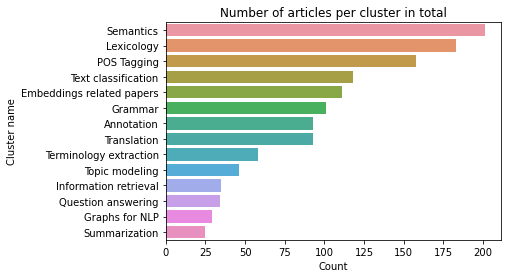

In [97]:
sns.barplot(y=['Semantics', 'Lexicology', 'POS Tagging', 'Text classification', 'Embeddings related papers', 'Grammar', 'Annotation', 'Translation', 'Terminology extraction', 'Topic modeling', 'Information retrieval', 'Question answering', 'Graphs for NLP', 'Summarization'], 
            x=df_fr['label'].astype(str).value_counts()).set(title='Number of articles per cluster in total', 
                                                             ylabel='Cluster name', xlabel='Count');
#plt.xticks(rotation=90)
#plt.show()

# LDA

*One of the most widely used method for topic modeling. <br> Topic modeling is a type of statistical modeling for discovering the abstract “topics” that occur in a collection of documents. Latent Dirichlet Allocation (LDA) is an example of topic model and is used to classify text in a document to a particular topic. It builds a topic per document model and words per topic model, modeled as Dirichlet distributions.*

### Find occurencies of words

In [98]:
import nltk
from nltk.tokenize import word_tokenize

In [99]:
df_fr['Text_tokenized'] = df_fr['Text'].apply(word_tokenize)

In [100]:
def intersection(lst1, lst2): 
    lst1 = list(lst1)
    lst2 = list(lst2)
    lst3 = [value for value in lst1 if value in lst2] 
    return lst3

In [101]:
df_fr['Text_tokenized_bg'] = df_fr.apply(lambda x: intersection(x['Text_tokenized'], x['words']), axis = 1)

In [102]:
from gensim.corpora.dictionary import Dictionary
from gensim import corpora, models

In [103]:
dictionary = gensim.corpora.Dictionary(list(df_fr['Text_tokenized_bg']))

In [104]:
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
bow_corpus = [dictionary.doc2bow(doc) for doc in list(df_fr['Text_tokenized_bg'])]

*LDA on the raw texts*

In [105]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=25, id2word=dictionary, passes=2, workers=2)

for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.071*"phras" + 0.044*"structur" + 0.040*"discour" + 0.027*"annot" + 0.024*"syntax" + 0.022*"regl" + 0.018*"segment" + 0.016*"acte" + 0.011*"linguist" + 0.011*"ressourc"
Topic: 1 
Words: 0.081*"term" + 0.036*"lexical" + 0.026*"ressourc" + 0.026*"sémant" + 0.024*"méthod" + 0.021*"docu" + 0.019*"sen" + 0.018*"graph" + 0.017*"nom" + 0.015*"verb"
Topic: 2 
Words: 0.050*"domain" + 0.036*"term" + 0.025*"segment" + 0.021*"lexiqu" + 0.016*"détect" + 0.015*"linguist" + 0.015*"thémat" + 0.014*"annot" + 0.012*"phras" + 0.012*"construct"
Topic: 3 
Words: 0.049*"segment" + 0.036*"résum" + 0.021*"lexical" + 0.020*"étiquet" + 0.015*"répons" + 0.015*"context" + 0.014*"unit" + 0.014*"phras" + 0.014*"structur" + 0.014*"term"
Topic: 4 
Words: 0.106*"term" + 0.055*"lexiqu" + 0.043*"terminolog" + 0.027*"regl" + 0.023*"sémant" + 0.021*"domain" + 0.019*"verb" + 0.019*"vari" + 0.014*"valid" + 0.014*"ressourc"
Topic: 5 
Words: 0.058*"verb" + 0.044*"syntax" + 0.044*"segment" + 0.032*"sémant" + 

In [106]:
from gensim import corpora, models

tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

*LDA on TF-IDF keywords, so we don't need to perform a data cleaning stopwords, very occurent vocabular specific to the field (such as the word "corpus", very used in NLP but never represented in the TF-IDF*

In [107]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=25, id2word=dictionary, passes=2, workers=4)
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.014*"sémant" + 0.013*"graph" + 0.013*"regl" + 0.012*"structur" + 0.011*"détect" + 0.011*"dépend" + 0.010*"segment" + 0.010*"quand" + 0.010*"traduct" + 0.010*"lexical"
Topic: 1 Word: 0.021*"résum" + 0.019*"annot" + 0.019*"répons" + 0.015*"dannot" + 0.014*"regl" + 0.014*"recherch" + 0.014*"mesur" + 0.013*"question" + 0.012*"phras" + 0.011*"segment"
Topic: 2 Word: 0.028*"grammair" + 0.019*"sémant" + 0.017*"structur" + 0.016*"noeud" + 0.015*"syntax" + 0.014*"géner" + 0.012*"contraint" + 0.012*"schem" + 0.011*"arbre" + 0.010*"concept"
Topic: 3 Word: 0.022*"model" + 0.018*"contraint" + 0.016*"acte" + 0.016*"cadr" + 0.014*"sémant" + 0.013*"énonc" + 0.013*"discour" + 0.012*"compréhens" + 0.012*"commun" + 0.011*"parol"
Topic: 4 Word: 0.021*"traduct" + 0.018*"phras" + 0.015*"model" + 0.012*"parallel" + 0.012*"syntax" + 0.011*"verb" + 0.011*"méthod" + 0.010*"lexical" + 0.010*"pair" + 0.009*"term"
Topic: 5 Word: 0.031*"définit" + 0.016*"term" + 0.014*"lexical" + 0.013*"sémant" + 0

*pyLDAvis is designed to help users interpret the topics in a topic model that has been fit to a corpus of text data. The package extracts information from a fitted LDA topic model to inform an interactive web-based visualization.* <br>
*Here you can see a visualisation of the two LDAs, the first one on the raw dataset and the second one on the TF-IDF keywords.*

In [108]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
panel = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dictionary, mds='tsne')
panel

PreparedData(topic_coordinates=               x          y  topics  cluster      Freq
topic                                                 
22    -31.058315  29.500683       1        1  6.962766
1     -21.461353 -17.436399       2        1  5.913311
20     -6.096575 -39.141697       3        1  5.593882
24     56.071609  -9.400822       4        1  5.342790
10     61.351185 -56.833744       5        1  4.830257
21     17.821402  57.413609       6        1  4.753011
16     49.250862  50.355305       7        1  4.695444
6     -13.172927  53.618752       8        1  4.619259
5      31.702734 -64.520691       9        1  4.393030
17     14.361623   7.507676      10        1  4.182473
7      29.184048 -13.613249      11        1  4.030348
12     19.284979 -39.023891      12        1  4.020473
8       4.356016 -15.153996      13        1  3.947159
14    -12.708655   6.676149      14        1  3.700282
0     -46.884609 -28.260098      15        1  3.630860
23    -28.764826 -54.799591      16        1  3.466403
15     62.600399  25.238491      17        1  3.320928
4     -43.313934   3.224185      18        1  3.223840
19     44.929001 -34.219784      19        1  2.997035
13     81.611572   3.921941      20        1  2.961051
2       0.798218  29.447706      21        1  2.931720
11      2.051419 -67.215591      22        1  2.903985
3      27.693497  31.413803      23        1  2.725475
9      40.470249   9.942824      24        1  2.634075
18     76.766655 -28.811687      25        1  2.220143, topic_info=         Term         Freq        Total Category  logprob  loglift
179      term  6608.000000  6608.000000  Default  30.0000  30.0000
121  question  2802.000000  2802.000000  Default  29.0000  29.0000
124    répons  2307.000000  2307.000000  Default  28.0000  28.0000
73   grammair  3960.000000  3960.000000  Default  27.0000  27.0000
55      phras  8157.000000  8157.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
28      franc    65.203148  2444.963623  Topic25  -4.8978   0.1833
108       nom    67.026016  3395.818604  Topic25  -4.8702  -0.1176
8    linguist    65.528969  2882.237549  Topic25  -4.8928   0.0238
285   perform    59.715351  1975.311890  Topic25  -4.9857   0.3087
62     sémant    60.291283  6946.693359  Topic25  -4.9761  -0.9392

[1366 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
183       1  0.041351      000
183       2  0.135331      000
183       3  0.011278      000
183       4  0.048869      000
183       5  0.063906      000
...     ...       ...      ...
127      17  0.073448  évident
127      18  0.016322  évident
127      19  0.048966  évident
127      21  0.065287  évident
127      22  0.008161  évident

[11216 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[23, 2, 21, 25, 11, 22, 17, 7, 6, 18, 8, 13, 9, 15, 1, 24, 16, 5, 20, 14, 3, 12, 4, 10, 19])

In [109]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
panel = pyLDAvis.gensim.prepare(lda_model_tfidf, corpus_tfidf, dictionary, mds='tsne')
panel

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
4     -31.058315  29.500683       1        1  13.380093
11    -21.461353 -17.436399       2        1   8.240639
15     -6.096575 -39.141697       3        1   8.083639
2      56.071609  -9.400822       4        1   6.856152
12     61.351185 -56.833744       5        1   5.896402
21     17.821402  57.413609       6        1   5.294274
16     49.250862  50.355305       7        1   5.048906
6     -13.172927  53.618752       8        1   4.447015
1      31.702734 -64.520691       9        1   4.328505
24     14.361623   7.507676      10        1   4.163280
13     29.184048 -13.613249      11        1   3.860362
18     19.284979 -39.023891      12        1   3.550746
3       4.356016 -15.153996      13        1   3.320964
14    -12.708655   6.676149      14        1   3.155413
9     -46.884609 -28.260098      15        1   2.879221
0     -28.764826 -54.799591      16        1   2.350591
5      62.600399  25.238491      17        1   2.019692
10    -43.313934   3.224185      18        1   1.933430
20     44.929001 -34.219784      19        1   1.919754
22     81.611572   3.921941      20        1   1.860257
19      0.798218  29.447706      21        1   1.649842
23      2.051419 -67.215591      22        1   1.610703
17     27.693497  31.413803      23        1   1.563425
7      40.470249   9.942824      24        1   1.525388
8      76.766655 -28.811687      25        1   1.061308, topic_info=         Term       Freq      Total Category  logprob  loglift
121  question  26.000000  26.000000  Default  30.0000  30.0000
193   traduct  48.000000  48.000000  Default  29.0000  29.0000
37      résum  18.000000  18.000000  Default  28.0000  28.0000
179      term  50.000000  50.000000  Default  27.0000  27.0000
124    répons  22.000000  22.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
62     sémant   0.389370  47.826313  Topic25  -4.9574  -0.2651
196     entit   0.343795  25.087854  Topic25  -5.0819   0.2556
91      model   0.372974  54.469315  Topic25  -5.0004  -0.4382
2      domain   0.344015  27.469019  Topic25  -5.0812   0.1655
76     niveau   0.327130  19.169146  Topic25  -5.1316   0.4750

[1391 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
183       1  0.161489      000
183       3  0.322977      000
183      15  0.161489      000
184       2  0.313845   accept
494       3  0.344036      acl
...     ...       ...      ...
225      19  0.063596    évalu
127       1  0.247208  évident
127       3  0.247208  évident
127       5  0.247208  évident
127       7  0.247208  évident

[2820 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 12, 16, 3, 13, 22, 17, 7, 2, 25, 14, 19, 4, 15, 10, 1, 6, 11, 21, 23, 20, 24, 18, 8, 9])

*The occuring words are very often the same, and it's very hard to determine a theme for each cluster, as we did for the first method with only the TF-IDF. We did not move forward with this experiment*

# Doc2Vec

*Word2Vec model:*

*Word2Vec is a more recent model that embeds words in a lower-dimensional vector space using a shallow neural network. The result is a set of word-vectors where vectors close together in vector space have similar meanings based on context, and word-vectors distant to each other have differing meanings. For example, strong and powerful would be close together and strong and Paris would be relatively far.*

In [110]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://scontent.fcdg2-1.fna.fbcdn.net/v/t1.15752-0/p480x480/129814332_3412162445566135_8592676798908282456_n.png?_nc_cat=111&ccb=2&_nc_sid=ae9488&_nc_ohc=LDr6MQ0suW8AX-1ULbL&_nc_ht=scontent.fcdg2-1.fna&_nc_tp=30&oh=0a5751351159123148ffa423a891dcc8&oe=5FF462D5")

*Doc2Vec model:*

*Le and Mikolov in 2014 introduced the Doc2Vec algorithm, which usually outperforms simple-averaging of Word2Vec vectors in each document.The basic idea is: act as if a document has another floating word-like vector, which contributes to all training predictions, and is updated like other word-vectors, but we will call it a doc-vector. Gensim’s Doc2Vec class implements this algorithm.*

In [111]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://scontent.fcdg2-1.fna.fbcdn.net/v/t1.15752-9/130188495_291514855630089_649236512466974312_n.png?_nc_cat=110&ccb=2&_nc_sid=ae9488&_nc_ohc=NRjmRrvWCH4AX8u7iNq&_nc_ht=scontent.fcdg2-1.fna&oh=3b54ef57735002018ec73ad57e138667&oe=5FF490CD")

*Learn paragraph and document embeddings via the distributed memory and distributed bag of words models from Quoc Le and Tomas Mikolov: “Distributed Representations of Sentences and Documents”.*

*we use the following process to extract relevant keywords per article and cluster them*

In [112]:
from IPython.display import Image
from IPython.core.display import HTML
Image(url= "https://scontent.xx.fbcdn.net/v/t1.15752-9/129639253_386918149191049_8858663096981549274_n.png?_nc_cat=105&ccb=2&_nc_sid=ae9488&_nc_ohc=etT_mY4WBAQAX-qxatt&_nc_ad=z-m&_nc_cid=0&_nc_ht=scontent.xx&oh=49e15a87373ce02486f9da2d4aa966cc&oe=5FF35C2C")

*We firstly build the model using gensim library*

In [113]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://scontent.fcdg2-1.fna.fbcdn.net/v/t1.15752-9/130166893_524790268478176_8345732758360303223_n.png?_nc_cat=102&ccb=2&_nc_sid=ae9488&_nc_ohc=veOL03DMKxYAX9i31Zv&_nc_ht=scontent.fcdg2-1.fna&oh=b166e5396b8b7e170584949af7ab14f3&oe=5FF2D061")

In [114]:
import nltk
import gensim

In [115]:
df_fr['tokenized_Text'] = df_fr.apply(lambda row: nltk.word_tokenize(row['Text']), axis=1)

In [116]:
sent = list(df_fr['tokenized_Text'])

In [117]:
# function to format the trajectory to be use in the DOC2VEC model

def LL_to_TGdoc(file=sent, tokens_only=False):

    for i, tokens in enumerate(file):
        if tokens_only:
                yield tokens
        else:
                # For training data, add tags
                yield gensim.models.doc2vec.TaggedDocument(tokens, [i])

In [118]:
train_corpus = list(LL_to_TGdoc()) 

###### Initializing and training the model

In [119]:
model = gensim.models.doc2vec.Doc2Vec(vector_size=200, min_count=2, epochs=40)

In [120]:
model.build_vocab(train_corpus)

In [121]:
model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)

#### Clustering using KMEANS

*we want to perform a clustering on these embeddings, before that we need to see which number of clustgers is the most appropriate*

#### Elbow method

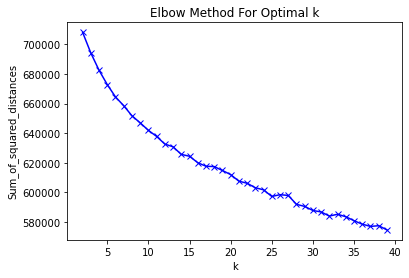

In [122]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

Sum_of_squared_distances = []
K = range(2,40)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(model.docvecs.vectors_docs)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

*We see that it is the same as the first model using the TF-IDF we can't clearly see the elbow range, but we think that the most appropriate is 14*

#### Silhouette score

*again the silhouette score is not of much help (it was very long and not very relevant so we just keep it as a markdown)*

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
print(__doc__)

X = model.docvecs.vectors_docs

range_n_clusters = list(range(2,40))

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, X.shape[0] + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

*We cluster the embeddings using KMEANS and the cosine distance, which is the most relevant when clustering embeddings*

In [125]:
from gensim.models import Word2Vec
from nltk.cluster import KMeansClusterer
import nltk
from sklearn import cluster
from sklearn import metrics

kclusterer = KMeansClusterer(14, distance=nltk.cluster.util.cosine_distance, repeats=25)
assigned_clusters = kclusterer.cluster(model.docvecs.vectors_docs, assign_clusters=True)
centroids = KMeansClusterer._centroid

In [126]:
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.decomposition import PCA
pca = PCA(n_components=3).fit(model.docvecs.vectors_docs)
datapoint = pca.transform(model.docvecs.vectors_docs)

df_plot3d = pd.DataFrame(list(zip(datapoint[:,0], datapoint[:,1], datapoint[:,2], assigned_clusters, df_fr['name'])), columns =['xs', 'ys', 'zs', 'clusters', 'title'])

import plotly.express as px

fig = px.scatter_3d(df_plot3d, x = 'xs',  
                    y = 'ys',  
                    z = 'zs', 
                    color = 'clusters',
                    title='3D scatter plot'
                    ) #text="title"
  
fig.show()

In [127]:

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2,
                                 use_idf=True, ngram_range=(1,1), stop_words= {'english', 'french'})

%time tfidf_matrix_no_stemming = tfidf_vectorizer.fit_transform(list(df_fr['Text_no_stemming'])) #fit the vectorizer to reviews
print(tfidf_matrix_no_stemming.shape)

Wall time: 3.14 s
(1285, 919)


### Word2Vec

#### importing a pre trained model of word2vec

In [128]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.test.utils import datapath
model = KeyedVectors.load_word2vec_format(r"C:\Users\hugop\Desktop\projet_nlp\word2vec_models\frWac_no_postag_no_phrase_500_cbow_cut100.bin", binary=True, unicode_errors="ignore")
#model = KeyedVectors.load_word2vec_format(datapath("frWac_no_postag_no_phrase_500_cbow_cut100.bin"), binary=True)

In [129]:
df_fr.head(2)

Text Language  \
0  considéron travail tâch trait automat vis cons...       fr   
1  donnon ici aperçu logiciel decid développ get ...       fr   

                                                name  date conference  \
0  Éléments de conception d'un système d'interpré...  1997       taln   
1  Informatisation du dictionnaire explicatif et ...  1997       taln   

                                    Text_no_stemming  count  \
0  considérons travail tâche traitement automatiq...      1   
1  donnons ici aperçu logiciel decid développé ge...      1   

                                 name_sans_stopwords  \
0  Éléments conception d'un système d'interprétat...   
1  Informatisation dictionnaire explicatif combin...   

                                               words  \
0  [état, situat, lieu, phas, qualit, valeur, par...   
1  [dictionnair, lexical, expliqu, création, info...   

                                                coef  \
0  [0.2885490618969356, 0.23818688697771648, 0.20...   
1  [0.5930071953318313, 0.28439185984980403, 0.23...   

                                          word_coeff  label  \
0  ([état, situat, lieu, phas, qualit, valeur, pa...      0   
1  ([dictionnair, lexical, expliqu, création, inf...     10   

                                      Text_tokenized  \
0  [considéron, travail, tâch, trait, automat, vi...   
1  [donnon, ici, aperçu, logiciel, decid, dévelop...   

                                   Text_tokenized_bg  \
0  [vis, interpret, vis, verbal, connaiss, lingui...   
1  [processus, dictionnair, expliqu, franc, lexic...   

                                      tokenized_Text  
0  [considéron, travail, tâch, trait, automat, vi...  
1  [donnon, ici, aperçu, logiciel, decid, dévelop...

*we validate our model using the following process:*

In [130]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://scontent.xx.fbcdn.net/v/t1.15752-9/130283912_200477435003470_8469482928838500412_n.png?_nc_cat=108&ccb=2&_nc_sid=ae9488&_nc_ohc=pdwgILPJ1lkAX8wP4yp&_nc_ad=z-m&_nc_cid=0&_nc_ht=scontent.xx&oh=dcac614aa7f04d33717b24172efc7bc3&oe=5FF397BE")

*first we retrieve the keywords and we input them in the pretrained Word2Vec model*

In [131]:
# Create a dataframe with the results
names = tfidf_vectorizer.get_feature_names()
data = tfidf_matrix_no_stemming.todense().tolist()
df_k = pd.DataFrame(data, columns=names)

#retrieving the top-10 most contributing words to the TF-IDF of each cluster
N = 10;
keywords= []
for i in df_k.iterrows():
    keywords.append(i[1].sort_values(ascending=False)[:10])

list_word=[]
for i in keywords:
    list_word.append(list(i.index))

list_coeff=[]
for i in keywords:
    list_coeff.append(list(i))

df_fr['words_no_stemming']=list_word
df_fr['coef_no_stemming']=list_coeff

list_word_coeff=[]
for i in range(len(list_coeff)):
    list_word_coeff.append(list(zip(list_word[i], list_coeff[i])))

In [134]:
liste = list(df_fr['words_no_stemming'])
liste_frequences = list(df_fr['coef_no_stemming'])
liste_text_representations = []
for i in range(len(liste)):
    for j in range(len(liste[i])):
        try:
            liste[i][j] = model.wv[liste[i][j]]*liste_frequences[i][j]
        except:
            liste[i][j] = [0]*500
df_fr['embeddings_frequences'] = liste

In [135]:
liste = list(df_fr['embeddings_frequences'])
for i in range(len(liste)):
    liste[i] = [sum(x) for x in zip(*liste[i])]
    liste[i] = [a/len(liste[i]) for a in liste[i]]
df_fr['embeddings_frequences'] = liste

#### Training the TF-IDF

In [137]:

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.05,
                                 use_idf=True, ngram_range=(1,1)) #, stop_words= {'english', 'french'}

%time tfidf_matrix_no_stemming = tfidf_vectorizer.fit_transform(list(df_fr['Text_no_stemming'])) #fit the vectorizer to reviews
print(tfidf_matrix_no_stemming.shape)

Wall time: 2.97 s
(1285, 3676)


In [288]:
terms = tfidf_vectorizer.get_feature_names()

In [294]:
# Create a dataframe with the results
names = tfidf_vectorizer.get_feature_names()
data = tfidf_matrix_no_stemming.todense().tolist()
df_k = pd.DataFrame(data, columns=names)

#retrieving the top-10 most contributing words to the TF-IDF of each cluster
N = 10;
keywords= []
for i in df_k.iterrows():
    keywords.append(i[1].sort_values(ascending=False))

list_word=[]
for i in keywords:
    list_word.append(list(i.index))

list_coeff=[]
for i in keywords:
    list_coeff.append(list(i))

df_fr['words_no_stemming']=list_word
df_fr['coef_no_stemming']=list_coeff

list_word_coeff=[]
for i in range(len(list_coeff)):
    list_word_coeff.append(list(zip(list_word[i], list_coeff[i])))

In [138]:
def list_of_words_to_embeddings(liste):
    liste_embeddings = []
    for i in liste:
        try:
            liste_embeddings.append(model.wv[i])
        except:
            liste_embeddings.append(False)
    return liste_embeddings

In [139]:
df_fr['words_no_stemming_embeddings'] = df_fr['words_no_stemming'].apply(lambda x: list_of_words_to_embeddings(x))

In [140]:
df_embeddings = df_fr[['name','words_no_stemming','coef_no_stemming','words_no_stemming_embeddings', 'label']]

In [141]:
#coefs liste de scores TF-IDF
#embeddings liste d'embeddings
def get_weighted_embedding(coefs, embeddings):
    #weighted_embeddings = []
    my_new_list = []
    for i in range(len(coefs)):
        #weighted_embeddings.append(coefs[i]*embeddings[i])
        if type(embeddings[i]) != type(False):
            #print('a')
            #print(coefs[i]*embeddings[i][1])
            my_new_list.append([coefs[i] * embeddings[i][j] for j in range(len(embeddings[i]))])
    #print(type(my_new_list))
    my_new_list = np.array(my_new_list)
    sum_embeddings = np.sum(my_new_list,0)
    sum_embeddings = sum_embeddings.tolist()
    #print(type(sum_embeddings))
    #sum_embeddings = list(map(sum, zip(*my_new_list)))
    result = [sum_embeddings[i] / sum(coefs) for i in range(len(sum_embeddings))]
    return result

In [145]:
df_embeddings['final_embedding'] = df_embeddings.apply(lambda x: get_weighted_embedding(x['coef_no_stemming'], x['words_no_stemming_embeddings']), axis = 1)

In [440]:
df_embeddings2 = df_embeddings[['name', 'label', 'final_embedding']]

In [442]:
%%time 
df_embeddings2.to_csv('dataset.csv', index=False, sep='$')

Wall time: 919 ms


In [517]:
df_embeddings['label'] = assigned_clusters

C:\Users\hugop\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



*to validate our approach we want to look at the standard deviation equivalent for W2V embeddings: we use the cosine distance instead of the euclidian distance*

In [459]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://geographyfieldwork.com/standa5.gif")

In [518]:
data = df_embeddings.groupby('label')['final_embedding'].apply(list)

In [519]:
data = list(data)

In [520]:
import math  

In [521]:
import numpy as np

mean_clusters = []
for i in range(len(data)):
    x = np.array(data[i])
    mean_clusters.append(list(np.average(x, axis=0)))

In [522]:
from scipy.spatial import distance

std_dev_clusters = []
for i in range(len(data)):
    result = 0
    n = len(data[i])
    c = mean_clusters[i]
    for j in range(len(data[i])):
        result += distance.cosine(data[i][j], c)**2
        #result += np.subtract(data[i][j], c)**2
    std_dev_clusters.append(np.sqrt(result/n))

In [523]:
std_dev_clusters

[0.08682693244320261,
 0.0942168712502819,
 0.10493284894970818,
 0.09429484204724847,
 0.09021395651914126,
 0.08263937259984444,
 0.10235457731313431,
 0.09393305187674522,
 0.08784751194086028,
 0.09470979199612804,
 0.09553440002010752,
 0.11318180509603533,
 0.08337886856951608,
 0.09708169902047657]

std_dev_clusters_mag = []
for i in range(len(std_dev_clusters)):
    std_dev_clusters_mag.append(np.linalg.norm(std_dev_clusters[i]))

std_dev_clusters_mag

In [524]:
data_tot = list(df_embeddings['final_embedding'])
x_tot = np.array(data_tot)
mean = list(np.average(x_tot, axis=0))

In [525]:
result = 0
n = len(data_tot)
c = mean
for i in range(len(data_tot)):
    #result += np.subtract(data_tot[i], c)**2
    result += distance.cosine(data_tot[i], c)**2
std_dev_totale = np.sqrt(result/n)

In [526]:
std_dev_totale

0.10970846958380959

*We wouldve liked to have a "cosine deviation" lower inside a cluster than in the whole dataframe to validate our approach*

*Hence the best method so far is the TF-IDF, and we have no way to validate our Doc2Vec approach*

#### Biais d'entrainement Word2Vec

*We noticed that there bias in the Word2Vec*

In [99]:
model.similarity('sentiment', 'sentiments')

0.31031406

In [97]:
model.similarity('force', 'femme')

0.11180353

In [98]:
model.similarity('force', 'homme')

0.38477954

In [245]:
model.similarity('ménage', 'homme')

-0.015962077

In [246]:
model.similarity('ménage', 'femme')

0.23140381

In [259]:
model.most_similar('sportif')

[('sport', 0.8138806819915771),
 ('sportive', 0.6021112203598022),
 ('multisport', 0.6008591651916504),
 ('loisir', 0.5874196290969849),
 ('sportifs', 0.5640065670013428),
 ('haut-niveau', 0.5586189031600952),
 ('sportives', 0.5552699565887451),
 ('multisports', 0.5441733598709106),
 ('pratiquant', 0.5319331884384155),
 ('omnisports', 0.5286290645599365)]